# Opening a New Coffee Shop

## Introduction

For the longest time, Seattle, Washington has been known as the coffee capital of the United States. According to a recent study in September 2019 by [WalletHub](https://wallethub.com/edu/best-cities-for-coffee-lovers/23739/), Seattle came out on top as the Best Coffee City in America. The study measured several metrics across the top 100 most populous cities in the United States. With the cold and dreary days experienced for most of the year, it makes sense that Seattleites have turned to the delicious concoction to stay warm. 

Suppose a person wanted to open a new shop in Seattle. Several considerations must be made to aid in its success. For example, the interior design is important in generating a welcoming environment to either stay and work or to bring customers in for the ever-growing popularity of aesthetic posts for social media. Another important factor, and arguably the most important, is location. Some neighborhoods may not have any coffee shops so opening one there may be a wise choice. However, in a populuous city like Seattle, littered with emerging tech companies, one may wonder if there is a possibility of a district having no coffee shop. Which area of Seattle should a new cafe open? The goal here is to leverage location data to understand the layout of the coffee shop industry in Seattle and to provide suggestion of which district to open a shop.

## Data

Two sources of data are used in this analysis. The first one is a data set that identifies all districts in the Seattle area found at this [link](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle). The data is scraped using the _pandas_ framework and preprocessed. In this data set, neighborhood and district are both reported but for the purposes here, only district is considered. 

The other source of data can be obtained from Foursquare location data. This data contains information on venues in the surrounding area and neighborhood, each categorized by type such as Coffee Shop, Park, etc. 

The data will be used to provide a suggestion on which district to open a coffee shop in Seattle.

In [128]:
# import all the necessary packages
import pandas as pd
import numpy as np
import folium
from geopy.geocoders import Nominatim

Let's first look at a map of Seattle, Washington. We can use Nominatim to obtain the latitude and longitude coordinates of the city for plotting.

In [129]:
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Seattle are {}, {}.'.format(latitude, longitude))
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=12)
map_seattle

The geograpical coordinates of Seattle are 47.6038321, -122.3300624.


### Downloading and Preprocessing the Data

In [130]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Seattle')[0]
df.head()

,Unnamed: 0,Neighborhood name,Within larger district,Annexed[41],Locator map,Street map,Image,Notes
0,1,North Seattle,Seattle,Various,NaN,NaN,NaN,North of the Lake Washington Ship Canal[42]
1,2,Broadview,North Seattle[42],1954[43],NaN,NaN,NaN,[44]
2,3,Bitter Lake,North Seattle[42],1954[43],NaN,NaN,NaN,[45]
3,4,North Beach / Blue Ridge,North Seattle[42],"1940,[43] 1954[43]",NaN,NaN,NaN,[46]
4,5,Crown Hill,North Seattle[42],"1907,[47] 1952,[43] 1954[43]",NaN,NaN,NaN,[48]


In the following few blocks of code, we will clean the data, remove unnecessary columns, check for NaNs, and remove the footnotes (e.g. [42]) found in the link. We will be dropping 'Neighborhood name' since we will be focusing on the broader area known as a district.

In [131]:
df.drop(['Unnamed: 0', 'Annexed[41]', 'Neighborhood name', 'Locator map', 'Street map', 'Image', 'Notes'], inplace=True, axis=1)
df.head()

,Within larger district
0,Seattle
1,North Seattle[42]
2,North Seattle[42]
3,North Seattle[42]
4,North Seattle[42]


In [132]:
df.columns = ['District']
df['District'] = df['District'].str.replace('(\[[0-9]+\])', '')
ind = df[df['District'].str.contains('/')].index # some Districts have a slash in the name
df.drop(ind, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,District
0,Seattle
1,North Seattle
2,North Seattle
3,North Seattle
4,North Seattle


In [133]:
# get unique district names
new_df = pd.DataFrame(df['District'].unique(), columns=['District'])
new_df.head()

,District
0,Seattle
1,North Seattle
2,Northgate
3,Lake City
4,Ballard


In [134]:
new_df.size

24

Let's obtain the geolocation data for these neighborhoods.

In [246]:
# create an empty list and populate it
lat_lng = []
for i in range(len(new_df)):
    locator = Nominatim(user_agent='seattleGeo')
    location = locator.geocode('{}, Seattle, WA'.format(new_df['District'][i]))
    if (location is not None):
        lat_lng.append({'District': new_df['District'][i], 'Latitude': location[1][0], 'Longitude': location[1][1]})
    else:
        lat_lng.append({'District': new_df['District'][i], 'Latitude': np.nan, 'Longitude': np.nan})

# convert list to pandas DataFrame
lat_lng_df = pd.DataFrame(lat_lng, columns=['District', 'Latitude', 'Longitude'])
lat_lng_df

,District,Latitude,Longitude
0,Seattle,47.602896,-122.339841
1,North Seattle,47.660773,-122.291497
2,Northgate,47.713153,-122.321231
3,Lake City,47.719162,-122.295494
4,Ballard,47.676507,-122.386223
5,Central Seattle,47.612694,-122.303205
6,Magnolia,47.646811,-122.399489
7,Queen Anne,47.639480,-122.360745
8,Capitol Hill,47.623831,-122.318369
9,Madison Park,47.635930,-122.280196


In [247]:
# remove the rows with no location data, ie where there are NaN's
lat_lng_df.dropna(axis=0, inplace=True)
lat_lng_df.reset_index(inplace=True, drop=True)
lat_lng_df

,District,Latitude,Longitude
0,Seattle,47.602896,-122.339841
1,North Seattle,47.660773,-122.291497
2,Northgate,47.713153,-122.321231
3,Lake City,47.719162,-122.295494
4,Ballard,47.676507,-122.386223
5,Central Seattle,47.612694,-122.303205
6,Magnolia,47.646811,-122.399489
7,Queen Anne,47.639480,-122.360745
8,Capitol Hill,47.623831,-122.318369
9,Madison Park,47.635930,-122.280196


In [248]:
lat_lng_df.to_csv('SeattleDistrictLocation.csv', index=False)

In [243]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, district in zip(lat_lng_df['Latitude'], lat_lng_df['Longitude'], lat_lng_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

In [138]:
# DELETED FOURSQUARE CREDENTIALS

In [139]:
LIMIT = 100
search_query = 'Coffee'
radius = 500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ea31c74c8cff26793f57751'},
 'response': {'venues': [{'id': '4a609aa8f964a520ebc01fe3',
    'name': 'Pegasus Coffee',
    'location': {'address': '711 3rd Ave',
     'crossStreet': 'at Cherry St',
     'lat': 47.603689,
     'lng': -122.332502,
     'labeledLatLngs': [{'label': 'display',
       'lat': 47.603689,
       'lng': -122.332502},
      {'label': 'entrance', 'lat': 47.603439, 'lng': -122.332401}],
     'distance': 183,
     'postalCode': '98104',
     'cc': 'US',
     'city': 'Seattle',
     'state': 'WA',
     'country': 'United States',
     'formattedAddress': ['711 3rd Ave (at Cherry St)',
      'Seattle, WA 98104',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referra

In [140]:
# get data frame format
shops = results['response']['venues']
shops_df = pd.json_normalize(shops)
shops_df.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.country,location.formattedAddress,location.neighborhood,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4a609aa8f964a520ebc01fe3,Pegasus Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1587747979,False,711 3rd Ave,at Cherry St,47.603689,-122.332502,"[{'label': 'display', 'lat': 47.603689, 'lng':...",...,United States,"[711 3rd Ave (at Cherry St), Seattle, WA 98104...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,545803de498e7e758ac5605e,Elm Coffee Roasters,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1587747979,False,240 2nd Avenue Ext S Ste 103,NaN,47.600152,-122.330944,"[{'label': 'display', 'lat': 47.60015237080675...",...,United States,"[240 2nd Avenue Ext S Ste 103, Seattle, WA 981...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4a848900f964a520e3fc1fe3,Cherry Street Coffee House,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1587747979,False,808 3rd Ave,btw Marion & Columbia,47.604511,-122.333010,"[{'label': 'display', 'lat': 47.60451120781553...",...,United States,"[808 3rd Ave (btw Marion & Columbia), Seattle,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,55fc6351498e081c6ae9a9c1,Slate Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1587747979,False,602 2nd Ave,James St,47.602270,-122.332549,"[{'label': 'display', 'lat': 47.60226958101576...",...,United States,"[602 2nd Ave (James St), Seattle, WA 98104, Un...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49d3e558f964a520225c1fe3,Cherry Street Coffee House,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1587747979,False,103 Cherry St,at 1st Ave,47.602767,-122.334151,"[{'label': 'display', 'lat': 47.6027673689831,...",...,United States,"[103 Cherry St (at 1st Ave), Seattle, WA 98104...",Seattle Central Business District,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in shops_df.columns if col.startswith('location.')] + ['id']
shops_df_filtered = shops_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
shops_df_filtered['categories'] = shops_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
shops_df_filtered.columns = [column.split('.')[-1] for column in shops_df_filtered.columns]

shops_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Pegasus Coffee,Coffee Shop,711 3rd Ave,at Cherry St,47.603689,-122.332502,"[{'label': 'display', 'lat': 47.603689, 'lng':...",183,98104,US,Seattle,WA,United States,"[711 3rd Ave (at Cherry St), Seattle, WA 98104...",NaN,4a609aa8f964a520ebc01fe3
1,Elm Coffee Roasters,Coffee Shop,240 2nd Avenue Ext S Ste 103,NaN,47.600152,-122.330944,"[{'label': 'display', 'lat': 47.60015237080675...",414,98104,US,Seattle,WA,United States,"[240 2nd Avenue Ext S Ste 103, Seattle, WA 981...",NaN,545803de498e7e758ac5605e
2,Cherry Street Coffee House,Coffee Shop,808 3rd Ave,btw Marion & Columbia,47.604511,-122.333010,"[{'label': 'display', 'lat': 47.60451120781553...",233,98104,US,Seattle,WA,United States,"[808 3rd Ave (btw Marion & Columbia), Seattle,...",NaN,4a848900f964a520e3fc1fe3
3,Slate Coffee,Coffee Shop,602 2nd Ave,James St,47.602270,-122.332549,"[{'label': 'display', 'lat': 47.60226958101576...",255,98104,US,Seattle,WA,United States,"[602 2nd Ave (James St), Seattle, WA 98104, Un...",NaN,55fc6351498e081c6ae9a9c1
4,Cherry Street Coffee House,Coffee Shop,103 Cherry St,at 1st Ave,47.602767,-122.334151,"[{'label': 'display', 'lat': 47.6027673689831,...",328,98104,US,Seattle,WA,United States,"[103 Cherry St (at 1st Ave), Seattle, WA 98104...",Seattle Central Business District,49d3e558f964a520225c1fe3
5,Storyville Coffee Company,Coffee Shop,1001 1st Ave,at Madison St,47.604759,-122.336362,"[{'label': 'display', 'lat': 47.60475923205166...",483,98104,US,Seattle,WA,United States,"[1001 1st Ave (at Madison St), Seattle, WA 981...",NaN,52d456c811d24128cdd7bc8b
6,Panama Hotel Tea & Coffee,Coffee Shop,607 S Main St,btwn 6th & Maynard Ave. S,47.599970,-122.326147,"[{'label': 'display', 'lat': 47.59997006448296...",520,98104,US,Seattle,WA,United States,"[607 S Main St (btwn 6th & Maynard Ave. S), Se...",NaN,4412e177f964a520db301fe3
7,Convoy Coffee,Coffee Shop,220 2nd Ave S,Washington,47.600664,-122.331409,"[{'label': 'display', 'lat': 47.6006639104788,...",366,98104,US,Seattle,WA,United States,"[220 2nd Ave S (Washington), Seattle, WA 98104...",NaN,55c4f721498ed4c878baeb55
8,Coffee Tree,Coffee Shop,905 8th Ave,at Marion St.,47.607388,-122.328003,"[{'label': 'display', 'lat': 47.60738843604867...",424,98104,US,Seattle,WA,United States,"[905 8th Ave (at Marion St.), Seattle, WA 9810...",NaN,4fa7fc2ae4b039aeed33d99e
9,Coffee Tree & Poke,Poke Place,613 9th Ave,NaN,47.605903,-122.325329,"[{'label': 'display', 'lat': 47.605903, 'lng':...",423,98104,US,Seattle,WA,United States,"[613 9th Ave, Seattle, WA 98104, United States]",NaN,57a257de498ece0bb183d2a3


As we can see in the output above, 'location.neighborhood' is NaN for several of these rows. We should iterate through each district and do the query that way.

In [157]:
# iterate through each neighborhood
LIMIT = 200
search_query = 'Coffee'
radius = 500
coffee = []
for dis, lat, lng in zip(lat_lng_df['District'], lat_lng_df['Latitude'], lat_lng_df['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    if (len(results['response']['venues']) != 0):
        shops = results['response']['venues']
        shops_df = pd.json_normalize(shops)
        filtered_columns = ['name', 'categories'] + [col for col in shops_df.columns if col.startswith('location.')] + ['id']
        shops_df_filtered = shops_df.loc[:, filtered_columns]
        shops_df_filtered['categories'] = shops_df_filtered.apply(get_category_type, axis=1)
        shops_df_filtered.columns = [column.split('.')[-1] for column in shops_df_filtered.columns]
        filtered_df = shops_df_filtered[['name', 'categories', 'lat', 'lng', 'id']]
        rep_df = pd.DataFrame([dis] * len(filtered_df), columns=['District'])
        dis_df = pd.concat([filtered_df, rep_df], axis=1)
        coffee.append(dis_df)

Combine all dataframes from the list 'coffee' into one large dataframe 'coffee_df'.

In [158]:
coffee_df = pd.concat(coffee)
coffee_df.reset_index(inplace=True, drop=True)
coffee_df.head()

,name,categories,lat,lng,id,District
0,Storyville Coffee Company,Coffee Shop,47.604759,-122.336362,52d456c811d24128cdd7bc8b,Seattle
1,Cherry Street Coffee House,Coffee Shop,47.602767,-122.334151,49d3e558f964a520225c1fe3,Seattle
2,Cherry Street Coffee House,Coffee Shop,47.604511,-122.333010,4a848900f964a520e3fc1fe3,Seattle
3,Slate Coffee,Coffee Shop,47.602270,-122.332549,55fc6351498e081c6ae9a9c1,Seattle
4,Convoy Coffee,Coffee Shop,47.600664,-122.331409,55c4f721498ed4c878baeb55,Seattle


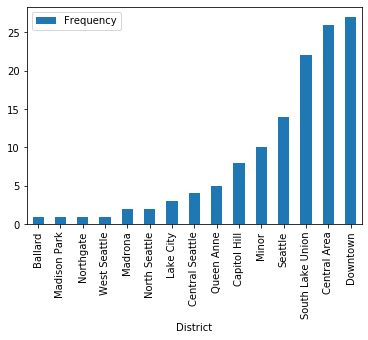

In [279]:
import matplotlib.pyplot as plt
cats = coffee_df.groupby('District').count()
cats_df = cats[['name']].sort_values('name')
cats_df.columns = ['Frequency']
cats_df.plot(kind='bar')

Let's look at a map of the coffee shops returned by Foursquare colored by district.

In [159]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_coffee = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
districts = coffee_df['District'].unique().tolist()
num_dis = len(coffee_df['District'].unique())
x = np.arange(num_dis)
ys = [i + x + (i*x)**2 for i in range(num_dis)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
colors_index = coffee_df['District'].apply(districts.index)

# add markers to the map
markers_colors = []
for nam, lat, lng, dis, ctr in zip(coffee_df['name'], coffee_df['lat'], coffee_df['lng'], coffee_df['District'], colors_index):
    label = folium.Popup('{}, {}'.format(nam, dis), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[ctr],
        fill=True,
        fill_color=rainbow[ctr],
        fill_opacity=0.7).add_to(map_coffee)
       
map_coffee

In [166]:
# iterate through each neighborhood
LIMIT = 200
radius = 500
venue = []
for dis, lat, lng in zip(lat_lng_df['District'], lat_lng_df['Latitude'], lat_lng_df['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    if (len(results['response']['venues']) != 0):
        venues = results['response']['venues']
        venues_df = pd.json_normalize(venues)
        filtered_columns = ['name', 'categories'] + [col for col in venues_df.columns if col.startswith('location.')] + ['id']
        venues_df_filtered = venues_df.loc[:, filtered_columns]
        venues_df_filtered['categories'] = venues_df_filtered.apply(get_category_type, axis=1)
        venues_df_filtered.columns = [column.split('.')[-1] for column in venues_df_filtered.columns]
        filtered_df = venues_df_filtered[['name', 'categories', 'lat', 'lng', 'id']]
        rep_df = pd.DataFrame([dis] * len(filtered_df), columns=['District'])
        dis_df = pd.concat([filtered_df, rep_df], axis=1)
        venue.append(dis_df)

In [170]:
venue_df = pd.concat(venue)
venue_df.reset_index(inplace=True, drop=True)
venue_df.head()

,name,categories,lat,lng,id,District
0,Seattle Ferry Terminal,Pier,47.602052,-122.338530,4283ee00f964a52082221fe3,Seattle
1,Bainbridge Island Ferry,Boat or Ferry,47.603144,-122.339028,50088716e4b08aad427581a9,Seattle
2,M/V Puyallup,Boat or Ferry,47.604514,-122.405441,4bb7c4afcf2fc9b69bc59e02,Seattle
3,Tacoma Ferry,Boat or Ferry,47.602870,-122.340050,58f2759f42d8c2387aa84c08,Seattle
4,No-idle Zone,Parking,47.602950,-122.338917,4e606231483bd9a9736d8b54,Seattle


Let's check how many venues were returned for each neighborhood

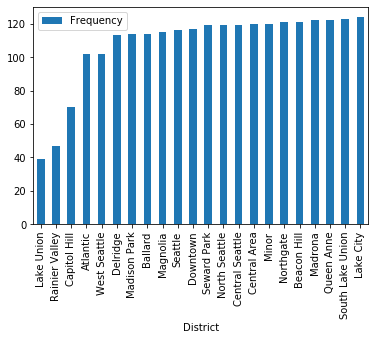

In [280]:
ven = venue_df.groupby('District').count()
ven_df = ven[['name']].sort_values('name')
ven_df.columns = ['Frequency']
ven_df.plot(kind='bar')

### Analyze Each Neighborhood

In [175]:
# one hot encoding
venues_onehot = pd.get_dummies(venue_df[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['District'] = venue_df['District'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,District,ATM,Accessories Store,Acupuncturist,Adult Education Center,Advertising Agency,African Restaurant,Airport Service,Alternative Healer,American Restaurant,...,Voting Booth,Warehouse,Waterfront,Weight Loss Center,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,Seattle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Seattle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Seattle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Seattle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Seattle,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [184]:
seattle_grouped = venues_onehot.groupby('District').sum().reset_index()
seattle_grouped.head()

,District,ATM,Accessories Store,Acupuncturist,Adult Education Center,Advertising Agency,African Restaurant,Airport Service,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Buddhist Temple,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Capitol Building,Car Wash,Cemetery,Chinese Restaurant,Chiropractor,Church,City Hall,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Rec Center,College Science Building,College Technology Building,Comedy Club,Comfort Food Restaurant,Community Center,Community College,Concert Hall,Conference Room,Convenience Store,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Drugstore,Dry Cleaner,EV Charging Station,Electronics Store,Elementary School,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fire Station,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,Frame Store,Fraternity House,French Restaurant,Frozen Yogurt Shop,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Pool,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Internet Cafe,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kingdom Hall,Kitchen Supply Store,Korean Restaurant,Laboratory,Lake,Language School,Latin American Restaurant,Laundry Service,Law School,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Medical Lab,Medical School,Mediterranean Restaurant,Meeting Room,Mental Health Office,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Military Base,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Mosque,Motel,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Nursery School,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Park,Parking,Pawn Shop,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Physical Therapist,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Police Station,Pool,Pool Hall,Post Office,Preschool,Print Shop,Prison,Professional & Other Places,Pub,Public Art,Real Estate Office,Record Shop

#### Let's print each neighborhood along with the top 5 most common venues

In [298]:
num_top_venues = 5

for hood in seattle_grouped['District']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Atlantic----
                 venue  freq
0             Bus Line   9.0
1      Automotive Shop   8.0
2  Government Building   6.0
3             Bus Stop   6.0
4             Building   4.0


----Ballard----
                                      venue  freq
0                                    Office   7.0
1                                  Bus Line   5.0
2                                    Church   5.0
3  Residential Building (Apartment / Condo)   4.0
4                                Playground   3.0


----Beacon Hill----
                                      venue  freq
0  Residential Building (Apartment / Condo)   6.0
1                                Food Truck   6.0
2                        Salon / Barbershop   5.0
3                        Mexican Restaurant   5.0
4                                    Church   5.0


----Capitol Hill----
                                      venue  freq
0  Residential Building (Apartment / Condo)   9.0
1                                   Dog Run   

In [186]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [230]:
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = seattle_grouped['District']

for ind in np.arange(seattle_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Atlantic,Bus Line,Automotive Shop,Government Building,Bus Stop,Building,Office,Bus Station,Meeting Room,Parking,Light Rail Station
1,Ballard,Office,Bus Line,Church,Residential Building (Apartment / Condo),Spiritual Center,School,Art Gallery,Playground,Professional & Other Places,Auditorium
2,Beacon Hill,Food Truck,Residential Building (Apartment / Condo),Salon / Barbershop,Mexican Restaurant,Church,Acupuncturist,Bus Station,Bank,Dentist's Office,Gas Station
3,Capitol Hill,Residential Building (Apartment / Condo),Dog Run,Bank,Gym / Fitness Center,Bed & Breakfast,Spa,General Entertainment,Gas Station,BBQ Joint,Housing Development
4,Central Area,Office,Lawyer,Art Gallery,Courthouse,Bus Stop,City Hall,Government Building,Police Station,Sandwich Place,Bus Line
5,Central Seattle,Food Truck,Coffee Shop,Salon / Barbershop,Building,Bus Stop,Laundry Service,General Entertainment,Church,Marijuana Dispensary,Ethiopian Restaurant
6,Delridge,Bus Line,Park,Garden,Bus Station,Playground,Speakeasy,Pizza Place,Gym,Building,Food Truck
7,Downtown,Office,Bus Stop,Tech Startup,Building,Lawyer,Bus Line,Coffee Shop,Conference Room,Sandwich Place,Bank
8,Lake City,Bus Station,Salon / Barbershop,Residential Building (Apartment / Condo),Bank,Asian Restaurant,Thai Restaurant,Dentist's Office,Mobile Phone Shop,Pet Store,Shipping Store
9,Lake Union,Boat or Ferry,Harbor / Marina,Bus Stop,Lake,Deli / Bodega,Mexican Restaurant,Bookstore,Massage Studio,Scenic Lookout,Sandwich Place


In [299]:
districts_venues_sorted.to_csv('DistrictsVenuesSorted.csv', index=False)

## Cluster Districts

In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
X = seattle_grouped.drop('District', axis=1)
cdf = StandardScaler().fit_transform(X)
num_clusters = 4
k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(cdf)
labels = k_means.labels_
unique, counts = np.unique(labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3], dtype=int32), array([ 1, 13,  4,  4]))

In [303]:
cdf.shape

(22, 367)

In [232]:
# add clustering labels
districts_venues_sorted.insert(0, 'ClusterLabels', k_means.labels_)

seattle_merged = lat_lng_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(districts_venues_sorted.set_index('District'), on='District')

seattle_merged.head() # check the last columns!

,District,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seattle,47.602896,-122.339841,1,Office,Boat or Ferry,Tech Startup,Pier,Gift Shop,Harbor / Marina,Building,Clothing Store,Burger Joint,Sandwich Place
1,North Seattle,47.660773,-122.291497,1,Doctor's Office,Dentist's Office,Salon / Barbershop,Medical Center,School,Office,Food Truck,Bus Stop,Kids Store,Bank
2,Northgate,47.713153,-122.321231,3,Dentist's Office,Office,Building,Doctor's Office,Assisted Living,Residential Building (Apartment / Condo),Bus Line,Arts & Crafts Store,Chiropractor,Bus Station
3,Lake City,47.719162,-122.295494,1,Bus Station,Salon / Barbershop,Residential Building (Apartment / Condo),Bank,Asian Restaurant,Thai Restaurant,Dentist's Office,Mobile Phone Shop,Pet Store,Shipping Store
4,Ballard,47.676507,-122.386223,2,Office,Bus Line,Church,Residential Building (Apartment / Condo),Spiritual Center,School,Art Gallery,Playground,Professional & Other Places,Auditorium


In [301]:
seattle_merged.size

308

In [233]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, dis, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['District'], seattle_merged['ClusterLabels']):
    label = folium.Popup(str(dis) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [237]:
seattle_merged.loc[seattle_merged['ClusterLabels'] == 0, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Central Seattle,Food Truck,Coffee Shop,Salon / Barbershop,Building,Bus Stop,Laundry Service,General Entertainment,Church,Marijuana Dispensary,Ethiopian Restaurant


In [238]:
seattle_merged.loc[seattle_merged['ClusterLabels'] == 1, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Seattle,Office,Boat or Ferry,Tech Startup,Pier,Gift Shop,Harbor / Marina,Building,Clothing Store,Burger Joint,Sandwich Place
1,North Seattle,Doctor's Office,Dentist's Office,Salon / Barbershop,Medical Center,School,Office,Food Truck,Bus Stop,Kids Store,Bank
3,Lake City,Bus Station,Salon / Barbershop,Residential Building (Apartment / Condo),Bank,Asian Restaurant,Thai Restaurant,Dentist's Office,Mobile Phone Shop,Pet Store,Shipping Store
8,Capitol Hill,Residential Building (Apartment / Condo),Dog Run,Bank,Gym / Fitness Center,Bed & Breakfast,Spa,General Entertainment,Gas Station,BBQ Joint,Housing Development
10,Lake Union,Boat or Ferry,Harbor / Marina,Bus Stop,Lake,Deli / Bodega,Mexican Restaurant,Bookstore,Massage Studio,Scenic Lookout,Sandwich Place
11,South Lake Union,Office,Food Truck,Coffee Shop,Hot Dog Joint,Rental Car Location,Parking,Café,Event Space,Art Gallery,Pizza Place
12,Downtown,Office,Bus Stop,Tech Startup,Building,Lawyer,Bus Line,Coffee Shop,Conference Room,Sandwich Place,Bank
13,Central Area,Office,Lawyer,Art Gallery,Courthouse,Bus Stop,City Hall,Government Building,Police Station,Sandwich Place,Bus Line
14,Minor,Office,Building,Café,Boat or Ferry,Parking,Doctor's Office,Medical Center,Coffee Shop,Event Space,Restaurant
15,Atlantic,Bus Line,Automotive Shop,Government Building,Bus Stop,Building,Office,Bus Station,Meeting Room,Parking,Light Rail Station


In [304]:
d = seattle_merged.loc[seattle_merged['ClusterLabels'] == 1, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]
d.to_csv('Cluster1.csv', index=False)

In [239]:
seattle_merged.loc[seattle_merged['ClusterLabels'] == 2, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Ballard,Office,Bus Line,Church,Residential Building (Apartment / Condo),Spiritual Center,School,Art Gallery,Playground,Professional & Other Places,Auditorium
6,Magnolia,Bus Stop,Building,Bank,Church,Playground,Office,Dentist's Office,Bus Station,Bookstore,Coffee Shop
9,Madison Park,Salon / Barbershop,Bus Stop,Office,Residential Building (Apartment / Condo),Dentist's Office,Bank,Park,Bar,Playground,Preschool
19,Seward Park,Salon / Barbershop,Church,Building,Synagogue,Park,Harbor / Marina,Ethiopian Restaurant,Trail,Nail Salon,Playground


In [305]:
d = seattle_merged.loc[seattle_merged['ClusterLabels'] == 2, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]
d.to_csv('Cluster2.csv', index=False)

In [240]:
seattle_merged.loc[seattle_merged['ClusterLabels'] == 3, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Northgate,Dentist's Office,Office,Building,Doctor's Office,Assisted Living,Residential Building (Apartment / Condo),Bus Line,Arts & Crafts Store,Chiropractor,Bus Station
7,Queen Anne,Bus Stop,Office,Dentist's Office,Yoga Studio,Nail Salon,Spa,Doctor's Office,Coffee Shop,Laundry Service,Mexican Restaurant
16,Madrona,Bus Stop,Office,Gift Shop,Boutique,Furniture / Home Store,Salon / Barbershop,Farmers Market,Art Gallery,Food & Drink Shop,Building
22,West Seattle,Doctor's Office,Church,Salon / Barbershop,Office,Cosmetics Shop,Spa,Bar,Medical Center,Miscellaneous Shop,Gas Station


In [306]:
d = seattle_merged.loc[seattle_merged['ClusterLabels'] == 3, seattle_merged.columns[[0] + list(range(4, seattle_merged.shape[1]))]]
d.to_csv('Cluster3.csv', index=False)